# Data Augmentation with Pytorch

In [1]:
import argparse
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Pytorch
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
import torch.optim as optim
from torch.autograd import Variable
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, ToTensor, Compose, RandomAffine
from torchvision import transforms
import torch.nn.functional as F

## Task and Plane

In [3]:
task = 'acl'
plane = 'axial'

## Seed

In [4]:
# PyTorch
torch.manual_seed(42)

# CuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Numpy
np.random.seed(42)

## 1. Single Image

In [5]:
# Load training data
folder_path = '../../data/train/{0}/'.format(plane)
records = pd.read_csv('../../data/train-{0}.csv'.format(task), header=None, names=['id', 'label'])
records['id'] = records['id'].map( lambda i: '0' * (4 - len(str(i))) + str(i) )
paths = [ folder_path + filename + '.npy' for filename in records['id'].tolist()]
labels = records['label'].tolist()

In [6]:
records.head()

id  label
0  0000      0
1  0001      1
2  0002      0
3  0003      0
4  0004      0

In [7]:
labels[:5]

[0, 1, 0, 0, 0]

In [8]:
# Get item
_index = 0
array = np.load(paths[_index])
label = labels[_index]

In [9]:
'Number of images on this slice: {}'.format(len(array))

'Number of images on this slice: 44'

In [10]:
# Get first image
image = array[0]

In [11]:
image

array([[ 0,  0,  0, ...,  5,  4,  3],
       [ 0,  0,  0, ...,  8,  6,  8],
       [ 0,  0,  0, ..., 14, 11, 11],
       ...,
       [ 0,  0,  0, ..., 16, 15, 12],
       [ 0,  0,  0, ..., 12, 13, 12],
       [ 0,  0,  0, ..., 11,  7,  9]], dtype=uint8)

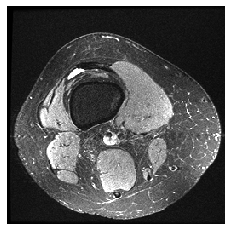

In [12]:
plt.axis("off")
plt.imshow(image, cmap='gray')
image_name = '../../augmentation/image.png'
plt.savefig(image_name)
plt.show()

In [13]:
# Augmentation
augmentor = transforms.Compose(
    [
        transforms.RandomVerticalFlip(p=1), # vertical flip, probability = 1
    ]
)

In [14]:
# Read image in PIL format
pil_image = Image.open(image_name)

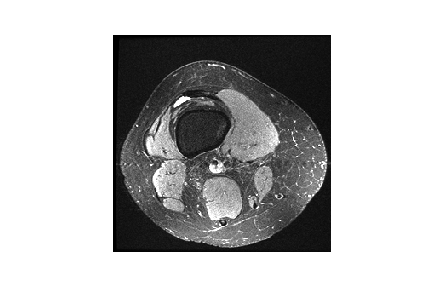

In [15]:
pil_image

In [16]:
# Transform
transformed_image = augmentor(pil_image)

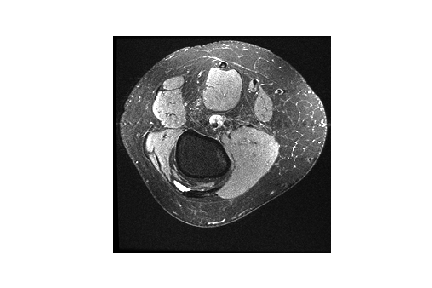

In [17]:
transformed_image

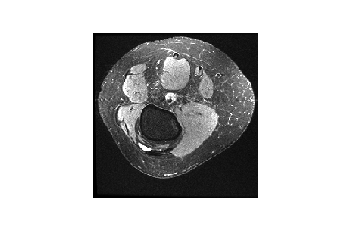

In [18]:
# Back to numpy array if needed
array = np.array(transformed_image)
image = Image.fromarray(array)

# Save image
plt.axis("off")
plt.imshow(transformed_image, cmap='gray')
plt.savefig('../../augmentation/vertical_flip.png')
plt.show()

## 2. Multiple Images using Pytorch's Dataloader

In [19]:
import torch
import torch.nn as nn
from torchvision import models


class MRNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.pretrained_model = models.alexnet(pretrained=True)
        self.pooling_layer = nn.AdaptiveAvgPool2d(1)
        self.classifer = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.squeeze(x, dim=0)
        features = self.pretrained_model.features(x)
        pooled_features = self.pooling_layer(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        flattened_features = torch.max(pooled_features, 0, keepdim=True)[0]
        output = self.classifer(flattened_features)
        return output

In [20]:
# Why 3 channels?
# All pre-trained models expect input images normalized in the same way, 
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
# https://pytorch.org/docs/stable/torchvision/models.html
CHANNELS = 3

class MRDataset(Dataset):

    def __init__(self, root_dir, task, plane, train=True, transform=None, weights=None):
        
        print('[DATALOADER] __init__ task: {}, plane: {}, train: {}'.format(task, plane, train))

        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train = train
        if self.train:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            transform = None
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map( lambda i: '0' * (4 - len(str(i))) + str(i) )
        self.paths = [ self.folder_path + filename + '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform
        if weights is None:
            pos = np.sum(self.labels)
            neg = len(self.labels) - pos
            self.weights = [1, neg / pos]
        else:
            self.weights = weights
    
    def __len__(self):

        print('[DATALOADER] __len__')
        
        return len(self.paths)

    def __getitem__(self, index):

        print('[DATALOADER] __getitem__ index: {}'.format(index))

        array = np.load(self.paths[index])
        print('Before transformation: {}'.format(array.shape))
        
        label = self.labels[index]
        label = torch.FloatTensor([label])

        if self.transform:
            array = np.stack([ self.transform(array[i]) for i in range(len(array)) ], axis=0)
            array = np.stack((array,) * CHANNELS, axis=1)
        else:
            array = np.stack((array,) * CHANNELS, axis=1)
            array = torch.FloatTensor(array)
            
        print('After transformation: {}'.format(array.shape))

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        return array, label, weight

In [21]:
def train_model(model, train_loader, epoch, num_epochs, optimizer):
    
    print('[TRAIN] Train model')

    _ = model.train()

    if torch.cuda.is_available():
        model.cuda()

    y_preds = []
    y_trues = []
    losses = []

    for i, (image, label, weight) in enumerate(train_loader):
        
        optimizer.zero_grad()

        # Copy to CUDA device
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        # Forward pass
        prediction = model.forward(image.float())
        loss = F.binary_cross_entropy_with_logits(
            prediction[0], label[0], weight=weight[0])

        # Backward and Optimize
        loss.backward()
        optimizer.step()

        # Prediction
        y_pred = torch.sigmoid(prediction).item()
        y_true = int(label.item())

        y_preds.append(y_pred)
        y_trues.append(y_true)

        # Metric
        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        # Loss
        loss_value = loss.item()
        losses.append(loss_value)
        
        print('{}. Train Loss: {:.4f},  Train AUC: {:.4f}, Label: {}, Weight: {:.4f}, Prediction: {:.4f}'.format(
            i + 1, loss_value, auc, y_true, weight.item(), y_pred))

        # Show just the first 4 patients
        if i == 4:
            return


**No Data Augmentation:**

In [22]:
train_dataset = MRDataset('../../data/', task, plane, transform=None, train=True)

[DATALOADER] __init__ task: acl, plane: axial, train: True


In [23]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, drop_last=False)

[DATALOADER] __len__
[DATALOADER] __len__


In [24]:
# Load one image
for batch_idx, data in enumerate(train_loader):

    array, label, weight = data

    print('## Batch ID: {}, label: {}, weight: {}'.format(batch_idx, label.item(), weight.item()))
    print('Shape of the array: {}'.format(array.shape))

    break

[DATALOADER] __len__
[DATALOADER] __getitem__ index: 236
Before transformation: (25, 256, 256)
After transformation: torch.Size([25, 3, 256, 256])
## Batch ID: 0, label: 1.0, weight: 4.432692527770996
Shape of the array: torch.Size([1, 25, 3, 256, 256])


In [25]:
array.shape

torch.Size([1, 25, 3, 256, 256])

In [26]:
def plot_slices(images_array, image_name, figsize=(12, 15)):
    
    print(images_array.shape)
    _, num_slices, _, _, _ = images_array.shape
    print('Number of slices: {}'.format(num_slices))

    cols = 5
    rows = num_slices // cols
    if num_slices % cols > 0: rows += 1

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize, dpi=100)
    axes_flattened = axes.flatten()

    for i in range(rows * cols):
        if i < num_slices:
            slice_array = images_array[0][i][0]
            axes_flattened[i].imshow(slice_array, cmap='gray')
            axes_flattened[i].set_title('Slice {}'.format(i))
        axes_flattened[i].axis('off')

    fig.tight_layout()
    
    plt.savefig('../../figures/{}'.format(image_name), bbox_inches='tight')
    
    plt.show()

torch.Size([1, 25, 3, 256, 256])
Number of slices: 25


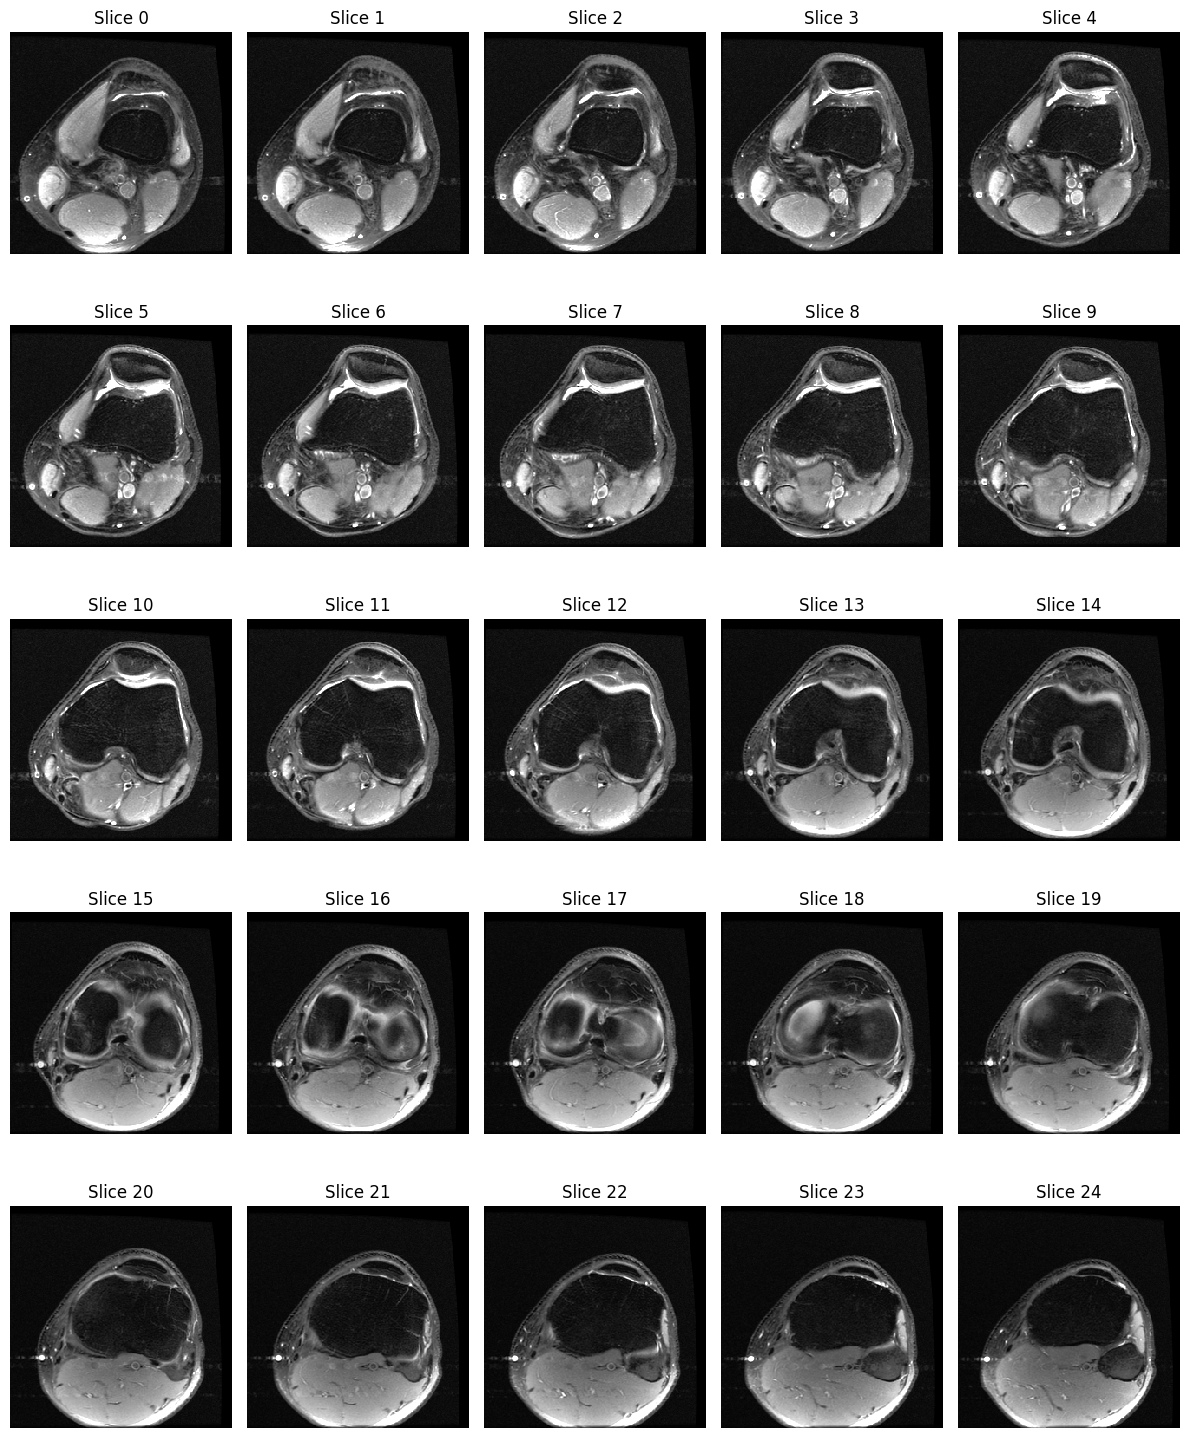

In [27]:
plot_slices(array, 'augmentation_I_pytorch_transformations_original.png', figsize=(12, 15))

In [28]:
mrnet = MRNet()
mrnet = mrnet.cuda()

In [29]:
epoch = 0
iteration_change_loss = 0
patience = 5
log_every = 20
num_epochs = 10

In [30]:
# Adam optimizer as well as a learning rate scheduler
optimizer = optim.Adam(mrnet.parameters(), lr=1e-5, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=3, factor=.3, threshold=1e-4, verbose=True)

In [31]:
train_model(mrnet, train_loader, epoch, num_epochs, optimizer)

[TRAIN] Train model
[DATALOADER] __len__
[DATALOADER] __getitem__ index: 150
Before transformation: (23, 256, 256)
After transformation: torch.Size([23, 3, 256, 256])
1. Train Loss: 22.2686,  Train AUC: 0.5000, Label: 1, Weight: 4.4327, Prediction: 0.0066
[DATALOADER] __getitem__ index: 818
Before transformation: (24, 256, 256)
After transformation: torch.Size([24, 3, 256, 256])
2. Train Loss: 0.0000,  Train AUC: 0.5000, Label: 0, Weight: 1.0000, Prediction: 0.0000
[DATALOADER] __getitem__ index: 156
Before transformation: (40, 256, 256)
After transformation: torch.Size([40, 3, 256, 256])
3. Train Loss: 0.1883,  Train AUC: 0.5000, Label: 0, Weight: 1.0000, Prediction: 0.1716
[DATALOADER] __getitem__ index: 458
Before transformation: (43, 256, 256)
After transformation: torch.Size([43, 3, 256, 256])
4. Train Loss: 3.8991,  Train AUC: 0.5000, Label: 1, Weight: 4.4327, Prediction: 0.4149
[DATALOADER] __getitem__ index: 477
Before transformation: (29, 256, 256)
After transformation: torch.

**Data Augmentation:**

In [32]:
augmentor = transforms.Compose([
    transforms.Lambda(lambda x: torch.Tensor(x)),
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(p = 1),
    transforms.Lambda(lambda x: np.array(x)),
])

In [33]:
# DATA AUGMENTATION
train_dataset_aug = MRDataset('../../data/', task, plane, transform=augmentor, train=True)

[DATALOADER] __init__ task: acl, plane: axial, train: True


In [34]:
train_loader_aug = torch.utils.data.DataLoader(
    train_dataset_aug, batch_size=1, shuffle=True, drop_last=False)

[DATALOADER] __len__
[DATALOADER] __len__


In [35]:
for batch_idx, data in enumerate(train_loader_aug):

    array, label, weight = data

    print('## Batch ID: {}, label: {}, weight: {}'.format(batch_idx, label.item(), weight.item()))

    print(array.shape)

    break

[DATALOADER] __len__
[DATALOADER] __getitem__ index: 580
Before transformation: (41, 256, 256)
After transformation: (41, 3, 256, 256)
## Batch ID: 0, label: 0.0, weight: 1.0
torch.Size([1, 41, 3, 256, 256])


In [36]:
array[0][0].shape

torch.Size([3, 256, 256])

torch.Size([1, 41, 3, 256, 256])
Number of slices: 41


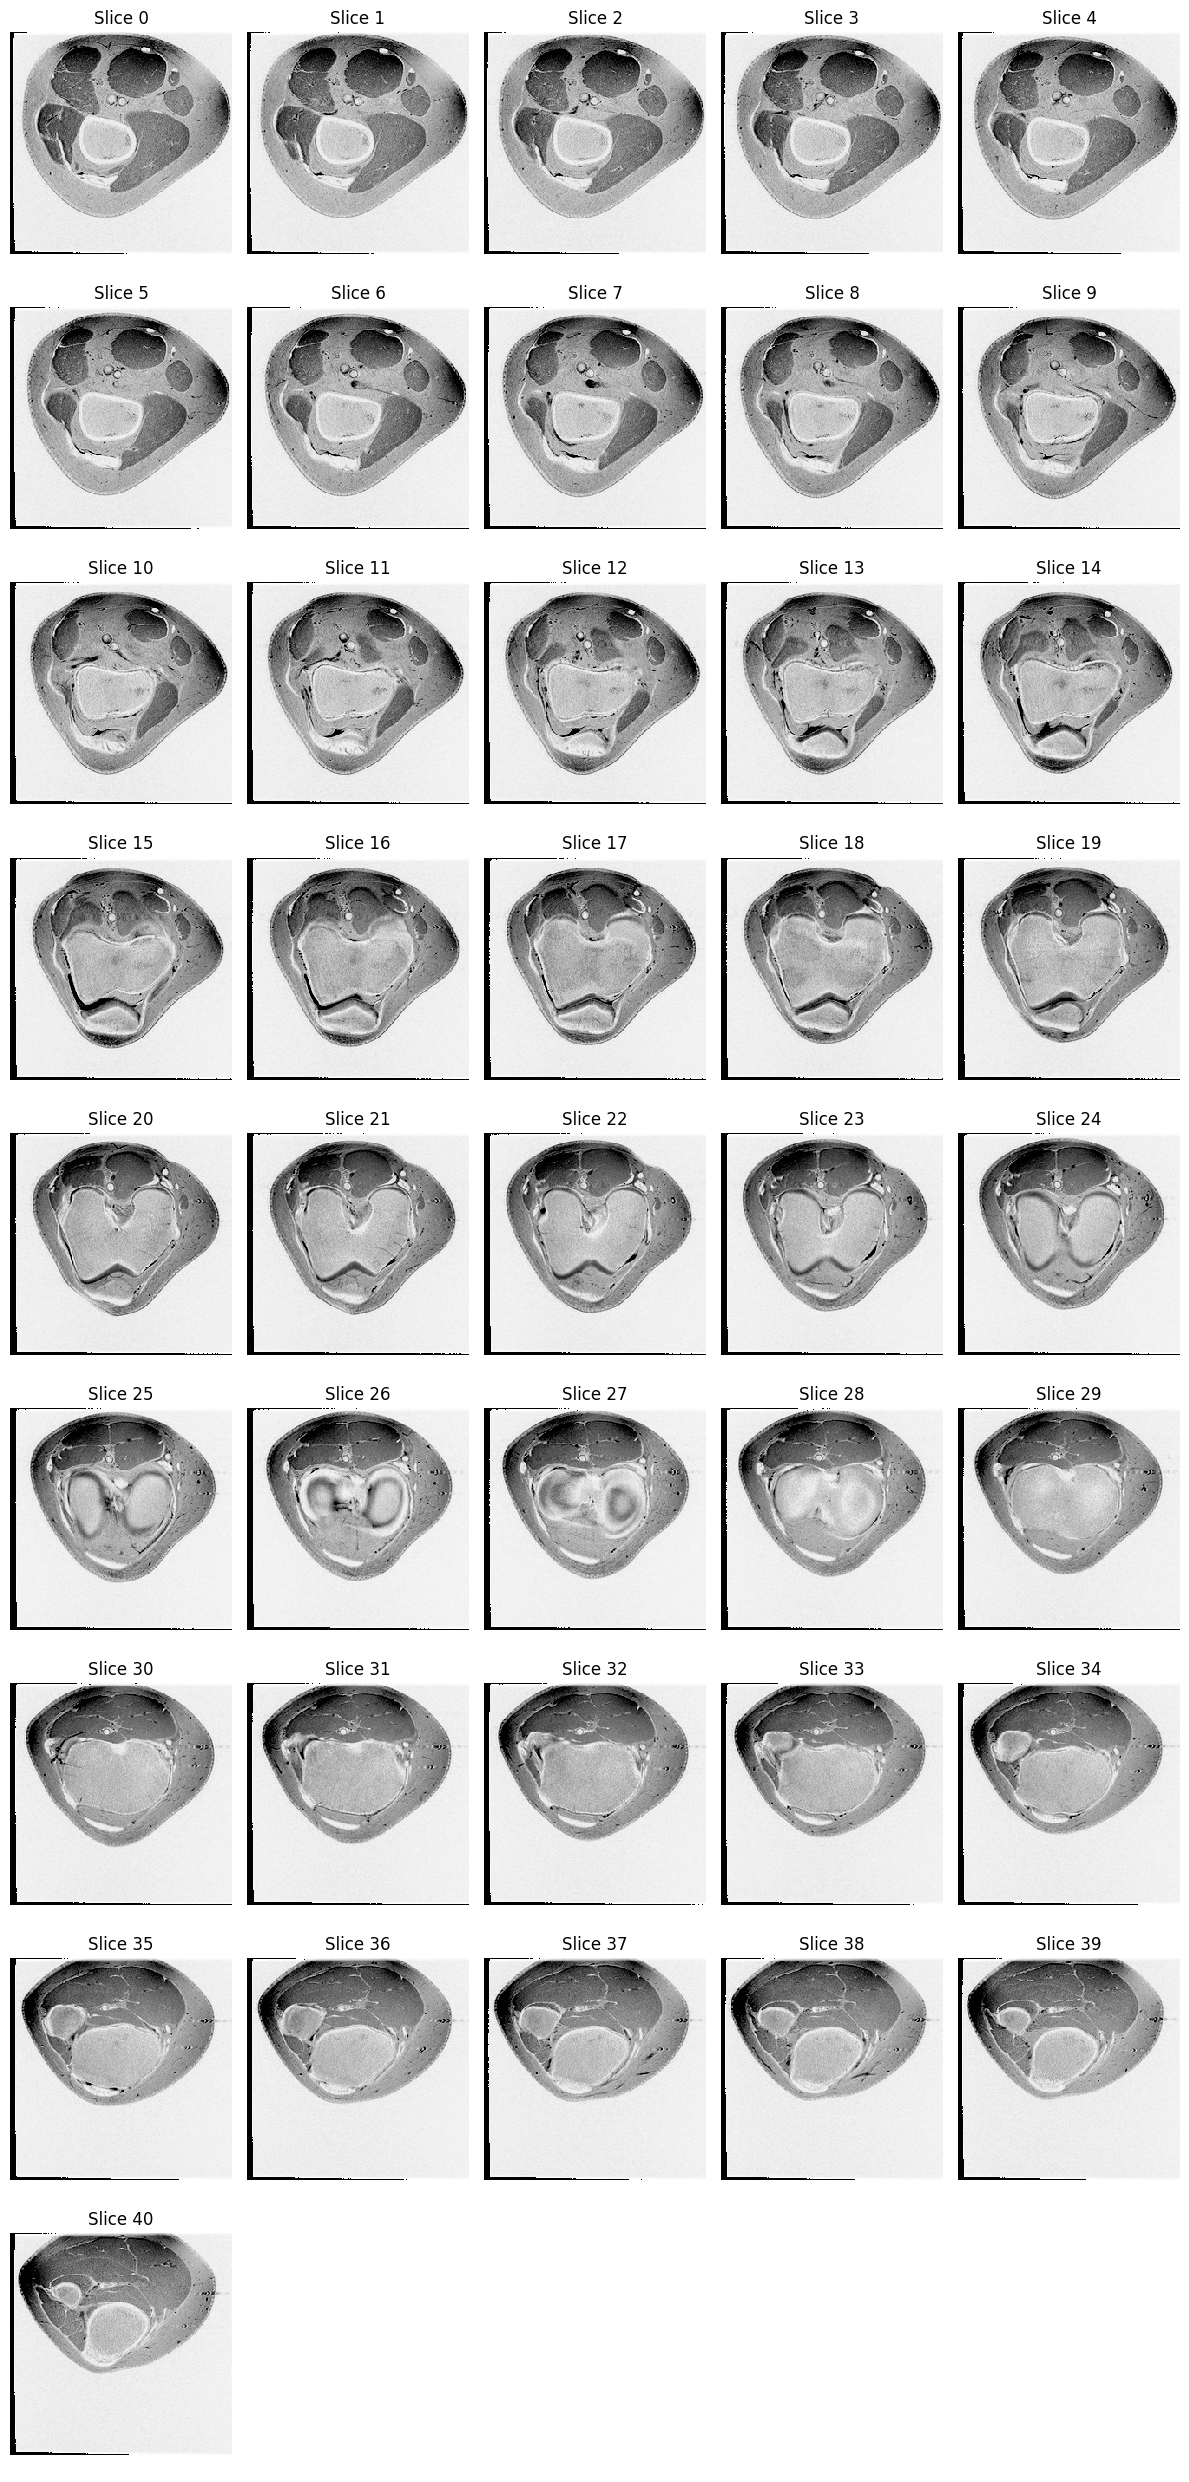

In [37]:
plot_slices(array, 'augmentation_I_pytorch_transformations_vertical_flip.png', figsize=(12, 25))

In [38]:
train_model(mrnet, train_loader_aug, epoch, num_epochs, optimizer)

[TRAIN] Train model
[DATALOADER] __len__
[DATALOADER] __getitem__ index: 23
Before transformation: (36, 256, 256)
After transformation: (36, 3, 256, 256)
1. Train Loss: 0.2437,  Train AUC: 0.5000, Label: 0, Weight: 1.0000, Prediction: 0.2163
[DATALOADER] __getitem__ index: 333
Before transformation: (46, 256, 256)
After transformation: (46, 3, 256, 256)
2. Train Loss: 0.0052,  Train AUC: 0.5000, Label: 0, Weight: 1.0000, Prediction: 0.0052
[DATALOADER] __getitem__ index: 845
Before transformation: (26, 256, 256)
After transformation: (26, 3, 256, 256)
3. Train Loss: 0.0001,  Train AUC: 0.5000, Label: 0, Weight: 1.0000, Prediction: 0.0001
[DATALOADER] __getitem__ index: 777
Before transformation: (21, 256, 256)
After transformation: (21, 3, 256, 256)
4. Train Loss: 0.0396,  Train AUC: 0.5000, Label: 0, Weight: 1.0000, Prediction: 0.0389
[DATALOADER] __getitem__ index: 993
Before transformation: (46, 256, 256)
After transformation: (46, 3, 256, 256)
5. Train Loss: 0.0001,  Train AUC: 0.5